In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

# import dataset
dataset = pd.read_csv("iris.data", names=['sepal length', 'sepal width', 'petal length', 'petal width', 'target'])

In [2]:
col = dataset.columns
features = col.tolist()
feature = features[:-1]
target = features[-1]
X = dataset.loc[:,feature].values
y = dataset.loc[:,target].values

# centre data
sc = StandardScaler(with_mean=True, with_std=False)
X = sc.fit_transform(X)

In [3]:
U, S, VT = np.linalg.svd(X, full_matrices=True) # compute matrices U, S and V (transpose)

# Calculate explained variance ratio to find top two principal components. USE THIS FOR PROGRESS REPORT
explained_variance = (S ** 2) / 4
explained_variance_ratio = explained_variance / explained_variance.sum()
cumulative_explained_variance = []
for i in range(len(explained_variance_ratio)):
    if i == 0:
        cumulative_explained_variance.append(explained_variance_ratio[i])
    else:
        cumulative_explained_variance.append(explained_variance_ratio[i]+cumulative_explained_variance[i-1])
        
        
print("Explained variance: ",explained_variance_ratio)
print("Cumulative explained variance: ",cumulative_explained_variance)

Explained variance:  [0.92461621 0.05301557 0.01718514 0.00518309]
Cumulative explained variance:  [0.9246162071742684, 0.9776317750248034, 0.9948169145498101, 1.0]


In [4]:
project = VT.dot(X.T) 

# keep only two  first principal components. Do not need last 2 features
project = np.delete(project, 2, 0)
project = np.delete(project, 2, 0)

principal_components = project.T
pc_dataframe = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])

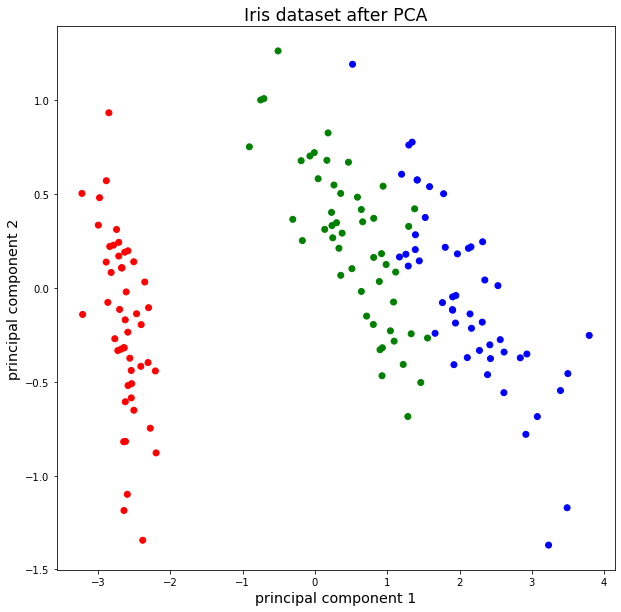

In [5]:
# table of principal components with their corresponding label
pc_dataframe_complete=pd.concat([pc_dataframe, dataset[['target']]], axis=1) 

# visualize the data-points of the Iris Dataset in 2 dimensions (2D) with their correct labels
plt.figure(figsize = (10,10))
pc_dataframe_complete['colours'] = pc_dataframe_complete.target.map({'Iris-setosa':'r', 'Iris-versicolor':'g', 'Iris-virginica':'b'})
plt.scatter(pc_dataframe_complete['principal component 1'], pc_dataframe_complete['principal component 2'], c=pc_dataframe_complete['colours'])
plt.title("Iris dataset after PCA", fontsize='xx-large')
plt.xlabel("principal component 1", fontsize='x-large')
plt.ylabel("principal component 2", fontsize='x-large')
# plt.savefig("pca.png")

del pc_dataframe_complete['colours'] # column no longer needed

In [6]:
def find_theta(dataset):
    """ Initialise theta parameters. This is the initialization step of the EM"""
    
    df = dataset[['principal component 1', 'principal component 2']]
    
    # use kmeans to find cluster centres
    k_means = KMeans(n_clusters=3, random_state=2)
    
    dataset['clusters'] = k_means.fit_predict(dataset) # store predictions of dataset
    centres = k_means.cluster_centers_
    mu1 = centres[0]
    mu2 = centres[1]
    mu3 = centres[2]
    
    data1 = dataset[dataset['clusters'] == 0]
    data2 = dataset[dataset['clusters'] == 1]
    data3 = dataset[dataset['clusters'] == 2]
    
    # K-means predictions no longer required to be stored in these datasets
    del data1['clusters']
    del data2['clusters']
    del data3['clusters']
    
    # initialize covariances using cluster assignments computed by kmeans
    sigma1 = np.cov(data1.T, bias=True)
    sigma2 = np.cov(data2.T, bias=True)
    sigma3 = np.cov(data3.T, bias=True)

    no_of_data = len(dataset)
    
    count_0 = 0
    count_1 = 0
    count_2 = 0
    for i in range(len(df)):
        if dataset.clusters[i] == 0:
            count_0 += 1
        elif dataset.clusters[i] == 1:
            count_1 += 1
        else:
            count_2 += 1
        
    # find weights of each cluster   
    weight1 = count_0 / no_of_data
    weight2 = count_1 / no_of_data
    weight3 = count_2 / no_of_data     
    
    return {'weight1':weight1, 'weight2': weight2, 'weight3':weight3,
           'mu1':mu1, 'mu2':mu2, 'mu3':mu3,
           'sigma1':sigma1, 'sigma2':sigma2, 'sigma3':sigma3}, k_means.labels_, k_means.inertia_, dataset, centres
    

theta, labels, squared_distances, data, centres = find_theta(pc_dataframe) 
print("Sum of squared errors: ", squared_distances)

Sum of squared errors:  63.8738380603623


In [7]:
def ground_truth_values(dataset, no_of_classes):
    """ Compute the griund truth values of the weight, mean and covariance of each cluster"""
    
    # used for computing ground truth values of mean and covariance
    size = dataset.shape[0]
    data_setosa = dataset[dataset['target'] == 'Iris-setosa']
    data_virginica = dataset[dataset['target'] == 'Iris-virginica']
    data_versicolor = dataset[dataset['target'] == 'Iris-versicolor']

    # labels no longer needed as dataset split into three other datasets depending on the label of each row
    del data_setosa['target']
    del data_virginica['target']
    del data_versicolor['target']
    
    # each class will have equal weight. This is the ground truth value for the weight of each class
    weight = 1 / no_of_classes
    
    # correct mean values for each of the clusters.
    mu_setosa = np.array(np.sum(data_setosa, axis=0) / len(data_setosa))
    mu_versicolor = np.array(np.sum(data_versicolor, axis=0) / len(data_versicolor))
    mu_virginica = np.array(np.sum(data_virginica, axis=0) / len(data_virginica))
    
    # correct covariance values for each of the clusters.
    sigma_setosa = np.array(np.cov(data_setosa.T, bias=True))
    sigma_versicolor = np.array(np.cov(data_versicolor.T, bias=True))
    sigma_virginica = np.array(np.cov(data_virginica.T, bias=True))
    
    return weight, mu_setosa, mu_versicolor, mu_virginica, sigma_setosa, sigma_versicolor, sigma_virginica

In [8]:
from sklearn.metrics import accuracy_score

def find_accuracy(theta, data, complete_data, model_name):
    """ Computes the accuracy of the model by comapring no. of correct predictions over all predictions"""
    # dictionary with keys the labels computed by the model and keys their corresponding type of flower
    map_targets = {0:'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

    predicted_values = []
    for i in range(len(pc_dataframe)):
        predicted_values.append(map_targets[data.labels[i]])

    data['labels'] = predicted_values
    
    accuracy = accuracy_score(complete_data.target, data.labels)
    print("Accuracy of", model_name, "is", accuracy*100, "%")

In [9]:
# compute ground truth values of theta parameters
weight, mu_setosa, mu_versicolor, mu_virginica, sigma_setosa, sigma_versicolor, sigma_virginica = ground_truth_values(pc_dataframe_complete, 3)

pc_dataframe['labels'] = labels # store in dataset labels computed by K-means
find_accuracy(theta, pc_dataframe, pc_dataframe_complete, "KMeans")
del pc_dataframe['labels']

Accuracy of KMeans is 88.66666666666667 %


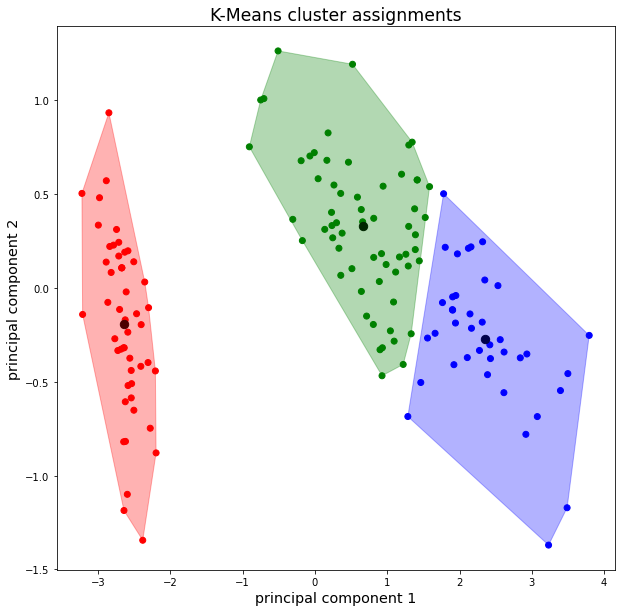

In [10]:
# plot fifure displaying cluster centres, cluster assignments and shapes of clusters computed by K-Means
plt.figure(figsize = (10,10))
data['colour_mapping'] = data.clusters.map({0:'r', 1:'g', 2:'b'})
plt.scatter(data['principal component 1'], data['principal component 2'], c=data['colour_mapping'])
plt.scatter(centres[:,0] , centres[:,1], color='black', s=70)
plt.title("K-Means cluster assignments", fontsize='xx-large')
plt.xlabel("principal component 1", fontsize='x-large')
plt.ylabel("principal component 2", fontsize='x-large')

c = ['r', 'g', 'b']
from scipy.spatial import ConvexHull
#draw cluster shape
for i in range(3):
    points = data[data.clusters == i][['principal component 1', 'principal component 2']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0], points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1], points[hull.vertices,1][0])
    plt.fill(x_hull, y_hull, alpha=0.3, c=c[i])
    
    
# plt.savefig("kmeans.png") 

In [11]:
def e_step(data, theta):
    """Soft assignment of data-points to each cluster"""
    responsibility_matrix = []
    for i in range(len(data)):
        resp = []
        r = []
        
        normal1 = scipy.stats.multivariate_normal(theta['mu1'], theta['sigma1'])
        normal2 = scipy.stats.multivariate_normal(theta['mu2'], theta['sigma2'])
        normal3 = scipy.stats.multivariate_normal(theta['mu3'], theta['sigma3'])
        
        responsibility1 = theta['weight1']*normal1.pdf(data.iloc[i]) # numerator value for cluster 1
        responsibility2 = theta['weight2']*normal2.pdf(data.iloc[i]) # numerator value for cluster 2
        responsibility3 = theta['weight3']*normal3.pdf(data.iloc[i]) # numerator value for cluster 3
        
        resp = [responsibility1, responsibility2, responsibility3]
        
        total_responsibility = np.sum(resp) # denominator value (used for normalization)
        
        # calculate responsibility
        resp1 = responsibility1 / total_responsibility
        resp2 = responsibility2 / total_responsibility
        resp3 = responsibility3 / total_responsibility
        r = [resp1, resp2, resp3] # single row of responsibility matrix, must sum up to 1
        responsibility_matrix.append(r)
                 
    return responsibility_matrix

In [12]:
def objective_function(data, responsibility_matrix, theta):
    """Compute loss. Objective function is the lower bound of loglikelihood."""
    
    # Use objective function mentioned in coursework specification
    likelihoods = []
    means = [theta['mu1'], theta['mu2'], theta['mu3']]
    weights = [theta['weight1'], theta['weight2'], theta['weight3']]
    covariances = [theta['sigma1'], theta['sigma2'], theta['sigma3']]
    for i in range(len(data)):
        for k in range(responsibility_matrix.shape[1]): # no. of clusters is 3
            responsibility = responsibility_matrix[i, k] # compute responsibility r_ik
            normal = scipy.stats.multivariate_normal(means[k], covariances[k])
            loglikelihood = np.log(normal.pdf(data.iloc[i])) # log p(x_i, z_i | Theta)
            likelihoods.append(np.multiply(loglikelihood, responsibility))
            
            
    return -np.sum(likelihoods) # negative sign -> want to minimize objective function          

In [13]:
def m_step(r_values, data):
    """Update parameters of theta"""
    
    cluster_1_resp = r_values[:,0] # responsibility values of cluster 1
    cluster_2_resp = r_values[:,1] # responsibility values of cluster 2
    cluster_3_resp = r_values[:,2] # responsibility values of cluster 3
    
    # update weight of each cluster
    # len(cluster_1_resp) = len(cluster_2_resp) = len(cluster_3_resp) = len(data)
    weight1 = np.sum(cluster_1_resp) /len(cluster_1_resp)
    weight2 = np.sum(cluster_2_resp) /len(cluster_2_resp)
    weight3 = np.sum(cluster_3_resp) /len(cluster_3_resp)
    
    # update mean of each cluster
    mu1 = (cluster_1_resp.dot(data)) / np.sum(cluster_1_resp)    
    mu2 = (cluster_2_resp.dot(data)) / np.sum(cluster_2_resp)
    mu3 = (cluster_3_resp.dot(data)) / np.sum(cluster_3_resp)
    
    # update covariance of each cluster
    sigma1 = (np.dot((data-mu1).T, (data-mu1)*cluster_1_resp[:,np.newaxis]) / np.sum(cluster_1_resp))
    sigma2 = (np.dot((data-mu2).T, (data-mu2)*cluster_2_resp[:,np.newaxis]) / np.sum(cluster_2_resp))
    sigma3 = (np.dot((data-mu3).T, (data-mu3)*cluster_3_resp[:,np.newaxis]) / np.sum(cluster_3_resp))
    
    theta = {'weight1':weight1, 'weight2':weight2, 'weight3':weight3,
             'mu1':mu1, 'mu2':mu2, 'mu3':mu3,
             'sigma1':sigma1, 'sigma2':sigma2, 'sigma3':sigma3}
    
    return theta

In [14]:
def run_em(data, theta):
    """ Runs EM algorithm until convergence"""
    loglikelihoods = [] # list storing the loglikelihood obtained during every iteration
    responsibilities_matrices = [] # list storing responsibility matrices obtained during every iteration
    parameters = [] # list storing theta parameters obtained during every iteration
    while True:
        if len(loglikelihoods) > 2:
            if abs(loglikelihoods[-1]-loglikelihoods[-2]) < 0.0001: # check if convergence achieved
                break
        r_matrix = e_step(data, theta)
        responsibilities = np.array(r_matrix)
        responsibilities_matrices.append(responsibilities)
        loss = objective_function(data, responsibilities, theta)
        loglikelihoods.append(loss)
        theta = m_step(responsibilities, pc_dataframe)
        parameters.append(theta)
        
        
    return parameters, loglikelihoods, responsibilities_matrices

best iteration is:  18
number of steps until convergence:  84
Iris-setosa weight:  0.33333333333331167     Ground truth value:  0.3333333333333333
Iris-versicolor weight:  0.31257195435449653    Ground truth value:  0.3333333333333333
Iris-virginica weight:  0.35409471231219186    Ground truth value:  0.3333333333333333
----------------------------------------------------------------------------------------------------
Iris-setosa mean [-2.64084076 -0.19051995]    Ground truth value:  [-2.64084076 -0.19051995]
Iris-versicolor mean  [0.51581429 0.22430507]    Ground truth value:  [0.53199262 0.24402963]
Iris-virginica mean  [ 2.03067469 -0.0186527 ]    Ground truth value:  [ 2.10884814 -0.05350968]
----------------------------------------------------------------------------------------------------
Iris-setosa covariance: 
[[ 0.04777048 -0.05590782]
 [-0.05590782  0.21472356]]
Ground truth value: 
[[ 0.04777048 -0.05590782]
 [-0.05590782  0.21472356]]
Iris-versicolor covariance: 
[[ 0.36

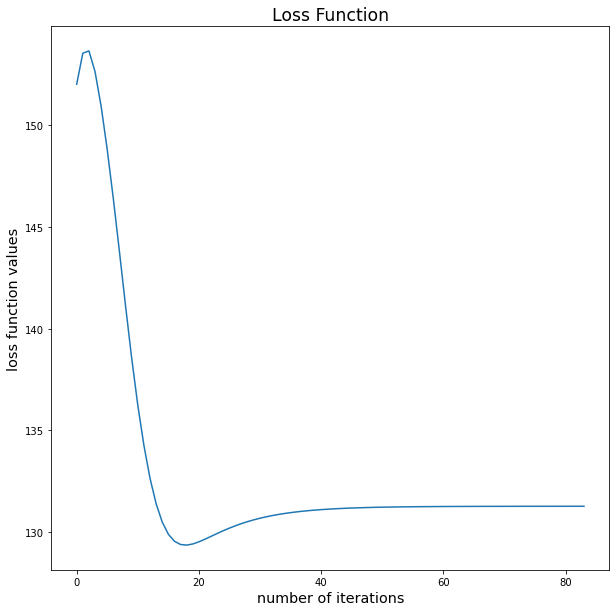

In [15]:
# cluster predictions provided by K-means and mapping no longer needed
del pc_dataframe['clusters']
del pc_dataframe['colour_mapping']

theta, loglikelihoods, responsibility_matrix = run_em(pc_dataframe, theta)
loglikelihoods = np.array(loglikelihoods)
smallest_loss = np.argmin(loglikelihoods) # find iteration that had the smallest loss
print("best iteration is: ", smallest_loss)
theta = theta[smallest_loss] # find theta calculated during the iteration with the smallest loss

# find responsibility values calculated during the iteration with the smallest loss
responsibility_matrix = responsibility_matrix[smallest_loss]
print("number of steps until convergence: ", len(loglikelihoods))

# plot loss function
plt.figure(figsize = (10,10))
plt.plot(loglikelihoods)
plt.title("Loss Function", fontsize='xx-large')
plt.xlabel("number of iterations", fontsize='x-large')
plt.ylabel("loss function values", fontsize='x-large')
# plt.savefig("loss-function.png")

# print theta values of iteration with the smallest loss and their corresponding ground truth values
print("Iris-setosa weight: ",theta['weight1'], "    Ground truth value: ", weight)
print("Iris-versicolor weight: ",theta['weight2'], "   Ground truth value: ", weight )
print("Iris-virginica weight: ",theta['weight3'], "   Ground truth value: ", weight)
print('-'*100)
print("Iris-setosa mean",theta['mu1'], "   Ground truth value: ", mu_setosa)
print("Iris-versicolor mean ",theta['mu2'], "   Ground truth value: ", mu_versicolor)
print("Iris-virginica mean ",theta['mu3'], "   Ground truth value: ", mu_virginica)
print("-"*100)
print("Iris-setosa covariance: ")
print(theta['sigma1'])
print("Ground truth value: ")
print(sigma_setosa)
print("Iris-versicolor covariance: ")
print(theta['sigma2'])
print("Ground truth value: ")
print(sigma_versicolor)
print("Iris-virginica covariance: ")
print(theta['sigma3'])
print("Ground truth value: ")
print(sigma_virginica)

In [16]:
from matplotlib.patches import Ellipse
import numpy as np
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

Accuracy of EM is 98.0 %


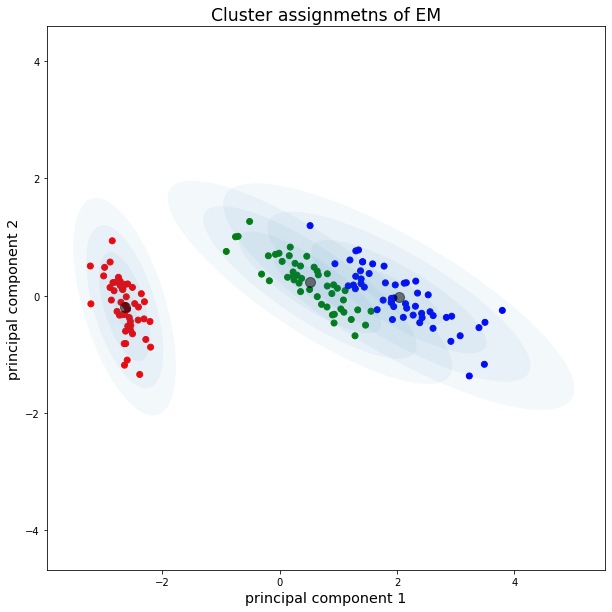

In [17]:
# plot shapes of clusters, and cluster assignments computed from the responsibility values calculated by EM
plt.figure(figsize = (10,10))
plt.axis('equal')
plt.title("Cluster assignmetns of EM", fontsize="xx-large")
plt.xlabel("principal component 1", fontsize="x-large")
plt.ylabel("principal component 2", fontsize="x-large")

centre1 = theta['mu1'] #center of ellipse (point of highest probability)
centre2 = theta['mu2'] #center of ellipse (point of highest probability)
centre3 = theta['mu3'] #center of ellipse (point of highest probability)

covar1 = theta['sigma1'] #shape of ellipse
covar2  = theta['sigma2'] #shape of ellipse
covar3 = theta['sigma3'] #shape of ellipse
alpha_factor = 1/20;  #controls the transparency of the displayed ellipse to simualte a region of probability

# hard assign data-points to clusters
predictions = []
for col in responsibility_matrix:
    predictions.append(np.argmax(col))
    
    
pc_dataframe['labels'] = predictions
pc_dataframe['colours'] = pc_dataframe.labels.map({0:'r', 1:'g', 2:'b'})
plt.scatter(pc_dataframe['principal component 1'], pc_dataframe['principal component 2'], c=pc_dataframe['colours'])

plt.scatter(centre1[0],centre1[1],c='black', s=100, alpha=0.5, zorder=2); #draw first center of ellipse
plt.scatter(centre2[0],centre2[1],c='black', s=100, alpha=0.5, zorder=2); #draw second center of ellipse
plt.scatter(centre3[0],centre3[1],c='black', s=100, alpha=0.5, zorder=2); #draw third center of ellipse

draw_ellipse(centre1, covar1, alpha = alpha_factor)
draw_ellipse(centre2, covar2, alpha = alpha_factor)
draw_ellipse(centre3, covar3, alpha = alpha_factor)

find_accuracy(theta, pc_dataframe, pc_dataframe_complete, "EM")
# plt.savefig("em.png")